In [4]:
import pandas as pd
import time
import numpy as np
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#import of rating data
# df_rating = pd.read_csv("Ratings.csv")

#import of songdata
df = pd.read_csv("song_data.csv")

#import of user data
# df_user = pd.read_csv("Users.csv")

#frequency binning the ages into age groups as it will be easier for future analysis
# df_user['age_group'] = pd.qcut(df_user['Age'],q=10,precision=0)
# df_book['year_group'] = pd.qcut(df_book['year'],q=10,precision=0)

#join all three dataframes
# df = pd.merge(df_rating, df_book, on='ISBN')
# df = pd.merge(df_rating, df_book, how='left', on='ISBN')
# df = pd.merge(df, df_user, on="User-ID")

# check for null valuesrating
df.isnull().sum()
df.drop_duplicates(inplace=True)

# book_counts = pd.DataFrame(df["Book-Title"].value_counts())
# book_counts.sort_values("Book-Title", ascending=False)
# rare_book = book_counts[book_counts["Book-Title"] <= 100].index
# common_book = df[~df["Book-Title"].isin(rare_book)]
# df = common_book

#drop unneccessary features
df.drop(["song_name", "audio_mode", "energy", "acousticness", "danceability", "loudness", "audio_mode", "speechiness", "audio_valence"], axis=1, inplace=True)

#categorize age_group, gender and occupation using 1-hot encoder
df['time_signature'] = pd.Categorical(df['time_signature'])
df['key'] = pd.Categorical(df['key'])
# df['Publisher'] = pd.Categorical(df['Publisher'])

time_signature_dummies = pd.get_dummies(df['time_signature'], prefix='time_signature')
key_dummies = pd.get_dummies(df['key'], prefix='key')
# publisher_dummies = pd.get_dummies(df['Publisher'], sparse=True)

df = pd.concat([df, time_signature_dummies, key_dummies], axis=1)

# Feature selection (Variance Inflation Factor, VIF)
df.drop(['time_signature', 'key', "time_signature_4", "key_1", "key_2", "key_3", "key_4", "key_5", "key_6", "key_7", "key_8", "key_9", "key_11"], axis=1, inplace=True)

#Removal of outlier:
for i in df:
    if i in ["song_duration_ms", "instrumentalness", "liveness", "tempo"]:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        df = df[df[i] <= (Q3 + (1.5 * IQR))]
        df = df[df[i] >= (Q1 - (1.5 * IQR))]
        df = df.reset_index(drop=True)
df.head()

,song_popularity,song_duration_ms,instrumentalness,liveness,tempo,time_signature_0,time_signature_1,time_signature_3,time_signature_5,key_0,key_10
0,73,262333,0.000029,0.0589,167.060,0,0,0,0,0,0
1,66,216933,0.000000,0.1080,105.256,0,0,0,0,0,0
2,74,216933,0.003550,0.1020,122.444,0,0,0,0,1,0
3,56,223826,0.000000,0.1130,172.011,0,0,0,0,0,1
4,80,235893,0.000002,0.3960,189.931,0,0,0,0,0,0


In [6]:
#Removal of outlier:
for i in df:
    if i in ["song_duration_ms", "instrumentalness", "liveness", "tempo"]:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        df = df[df[i] <= (Q3 + (1.5 * IQR))]
        df = df[df[i] >= (Q1 - (1.5 * IQR))]
        df = df.reset_index(drop=True)
df.head()

,song_popularity,song_duration_ms,instrumentalness,liveness,tempo,time_signature_0,time_signature_1,time_signature_3,time_signature_5,key_0,key_10
0,73,262333,0.000029,0.0589,167.060,0,0,0,0,0,0
1,66,216933,0.000000,0.1080,105.256,0,0,0,0,0,0
2,56,223826,0.000000,0.1130,172.011,0,0,0,0,0,1
3,80,222586,0.000000,0.0926,148.112,0,0,0,0,0,0
4,78,168253,0.000000,0.2630,161.944,0,0,0,0,0,0


In [7]:
#Feature Scaling (Standardization)
std = StandardScaler()
X = df.drop('song_popularity',axis=1,)
X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

y = df['song_popularity'].to_numpy()
X = X_std.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 1607
K = int(total_samples/T)

p = 1.5
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

In [8]:
get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

In [9]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)

array([ 7.        ,  3.5       ,  2.33333333, ..., 15.68037383,
       15.67372354, 15.66521469])

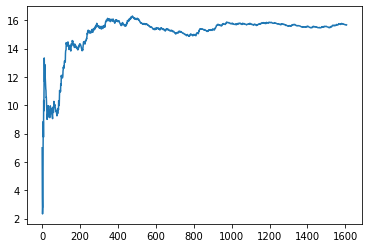

In [10]:
plt.plot(error_list)
error_list

In [9]:
df_2 = pd.read_csv("song_data.csv")
df_2 = df_2.drop(["song_name"], axis=1)
df_2.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [10]:
y2 = df_2['song_popularity'].to_numpy()
X2 = df_2.drop('song_popularity',axis=1,).to_numpy()
dim2 = X2.shape[1]
total_samples2 = len(y2)

T2 = 3767
K2 = int(total_samples2/T2)

p = 1.5
S = 1.

D2 = np.reshape(X2, (T2,K2,dim2))
R2 = np.reshape(y2, (T2,K2))

In [11]:
get_mean2 = lambda x, y2: R2[y2]
get_observation2 = lambda x, y2, z: R2[y2][z]

In [12]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
error_list2, theta_star2 = TOFU(D2, get_mean2, get_observation2, S=S, lamb=1., delta=0.01, p=p, b=1.)
# error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)

array([ 3.        ,  2.        ,  1.33333333, ..., 16.58486056,
       16.58231545, 16.57791346])

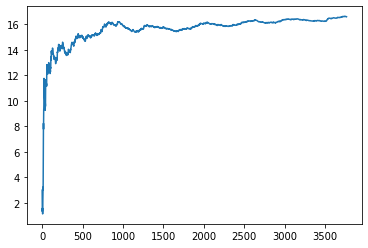

In [13]:
plt.plot(error_list2)
error_list2